Residual mean: tensor(-1.3323, grad_fn=<MeanBackward0>)
Loss: tensor(721.7508, grad_fn=<AddBackward0>)
parameters None
parameters tensor([12.9601])
Residual mean: tensor(-1.3330, grad_fn=<MeanBackward0>)
Loss: tensor(721.7379, grad_fn=<AddBackward0>)
parameters None
parameters tensor([12.8594])
Residual mean: tensor(-1.3337, grad_fn=<MeanBackward0>)
Loss: tensor(721.7251, grad_fn=<AddBackward0>)
parameters None
parameters tensor([12.7586])
Residual mean: tensor(-1.3344, grad_fn=<MeanBackward0>)
Loss: tensor(721.7124, grad_fn=<AddBackward0>)
parameters None
parameters tensor([12.6577])
Residual mean: tensor(-1.3352, grad_fn=<MeanBackward0>)
Loss: tensor(721.6998, grad_fn=<AddBackward0>)
parameters None
parameters tensor([12.5568])
Residual mean: tensor(-1.3359, grad_fn=<MeanBackward0>)
Loss: tensor(721.6874, grad_fn=<AddBackward0>)
parameters None
parameters tensor([12.4558])
Residual mean: tensor(-1.3366, grad_fn=<MeanBackward0>)
Loss: tensor(721.6750, grad_fn=<AddBackward0>)
parameter

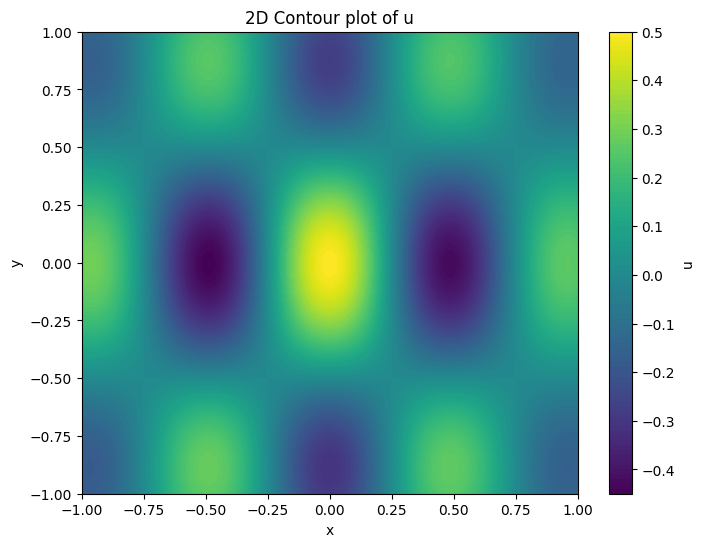

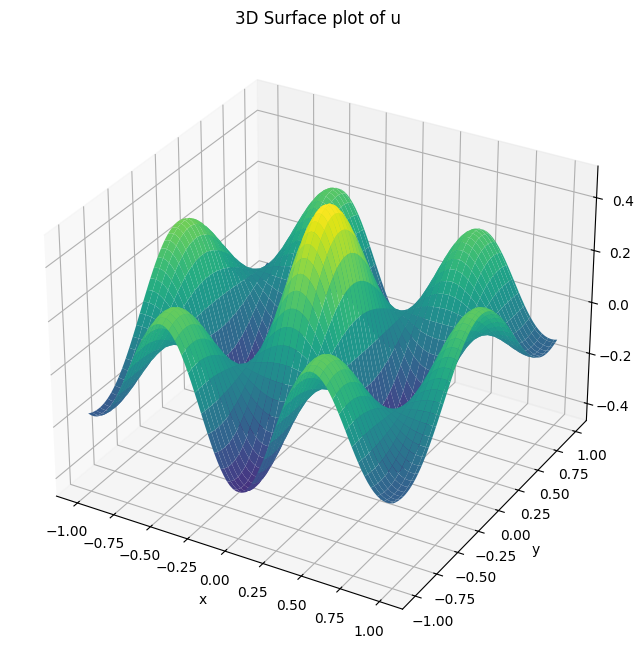

In [110]:
from qadence import (feature_map, hea, Z, QuantumModel, add, QuantumCircuit, 
                     kron, FeatureParameter, RX, RZ, VariationalParameter, RY,
                     chain, CNOT, X, Y, CRX, CRZ, I)
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize
import torch
from sympy import exp
from mpl_toolkits.mplot3d import Axes3D

#Constant and boundary conditions
k = 1
xmin = -1  
xmax = 1  
ymin = -1
ymax = 1
omega1 = np.pi
omega2 = 2*np.pi

torch.manual_seed(42)

def vqc_fit(n_qubits, n_epochs, x_range, y_range, xmin, xmax, k):
    
    x = FeatureParameter("x")
    y = FeatureParameter("y")
    phi = VariationalParameter("phi")
    
    block = chain(
        kron(RX(0, np.sqrt(k) * x + phi), RX(1, np.sqrt(k) * y + phi)),
        kron(RY(0, omega1 * x), RY(1, omega2 * y))  # Ensure sinusoids are learned
    ) 
    obs = (1 / (1 + k**2)) * kron(Z(0), Z(1))
        
    circuit = QuantumCircuit(2, block)
    model = QuantumModel(circuit, observable = obs)
    
    # Example of a learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for _ in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x_range, y_range, xmin, xmax, k)
        print("Loss:", loss)
        loss.backward()
        # Check gradients
        for param in model.parameters():
            print('parameters',param.grad)  # Check if gradients are being computed
        optimizer.step()
    # Generate predictions for the entire grid
    x_grid, y_grid = torch.meshgrid(x_range, y_range)
    u_pred = model.expectation({"x": x_grid.flatten(), "y": y_grid.flatten()}).squeeze().detach()
    u_pred = u_pred.reshape(x_grid.shape)

    return model, u_pred
    
#Once again, we need to adapt the loss function to enforce the diff. eq.

x_range = torch.linspace(-1, 1, 100)  # range of t values
y_range = torch.linspace(-1, 1, 100)  # range of t values


def loss_fn(model, x_range, y_range, xmin, xmax, k):
    
    x_range = x_range.clone().detach().requires_grad_(True)
    y_range = y_range.clone().detach().requires_grad_(True)
    
    us = model.expectation({"x": x_range, "y": y_range}).squeeze()
    
    # Compute second derivates
    dxs = torch.autograd.grad(us.sum(), x_range, create_graph=True)[0]
    dxs2 = torch.autograd.grad(dxs.sum(), x_range, create_graph=True)[0]
    
    dys = torch.autograd.grad(us.sum(), y_range, create_graph=True)[0]
    dys2 = torch.autograd.grad(dys.sum(), y_range, create_graph=True)[0]
    
    # forcing term 
    q_x_y = (k**2 - omega1**2 - omega2**2) * torch.sin(omega1 * x_range) * torch.sin(omega2 * y_range)
    
    # Check if learned derivative is behaving according to diff eq.
    residual = dxs2 + dys2 + k**2 * us - q_x_y
    
    # Enforce Dirichlet boundary conditions: u(x, ±1) = 0 and u(±1, y) = 0
    boundary_loss = (
        torch.mean(us[x_range == xmin]) +
        torch.mean(us[x_range == xmax]) +
        torch.mean(us[y_range == ymin]) +
        torch.mean(us[y_range == ymax])
    )
    
    # Total loss: MSE of residual and boundary conditions
    loss = torch.mean(residual**2) + torch.abs(boundary_loss*100)
    
    # Check if residual is meaningful
    print("Residual mean:", residual.mean())   
    
    return loss

def plot_2d(x_range, y_range, u_pred):
    plt.figure(figsize=(8, 6))
    
    x, y = np.meshgrid(x_range.detach().numpy(), y_range.detach().numpy())
    u = u_pred.detach().numpy().reshape(x.shape)
    
    plt.contourf(x, y, u, levels=100, cmap='viridis')
    plt.colorbar(label='u')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Contour plot of u')
    plt.show()

def plot_3d(x_range, y_range, u_pred):
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    x, y = np.meshgrid(x_range.detach().numpy(), y_range.detach().numpy())
    u = u_pred.detach().numpy().reshape(x.shape)
    
    ax.plot_surface(x, y, u, cmap='viridis')
    ax.set(xlabel='x', ylabel='y', zlabel='u')
    ax.set_title('3D Surface plot of u')
    plt.show()

show = True

n_qubits = 2
model, u_p = vqc_fit(n_qubits, 100, x_range, y_range, xmin, xmax, k)
print(x_range, y_range, u_p)
if show:
    plot_2d(x_range,y_range, u_p)
    plot_3d(x_range,y_range, u_p)
vparams = model.vparams